In [198]:
import os
import sys

sys.path.append('/Users/fllorente/Dropbox/con_Petar/PYTHON/gp_fusion')

from modules.data_handling import load_data  # Same as using Dataset but X and Y have std dv = 1 column-wise

from uci_datasets import Dataset
import matplotlib.pyplot as plt

In [199]:
dataset_names = ["autos", 'housing','stock','sml',
                 'elevators','breastcancer','forest','gas',
                 ]


dataset_name = dataset_names[1]
full_dataset = Dataset(dataset_name)
N,DIM = full_dataset.x.shape


# load_data uses the normalized dataset, i.e., full_dataset.x and full_dataset.y have unit variance
split = 0
X_train,y_train,X_test,y_test,_ = load_data(dataset_name,split)

housing dataset, N=506, d=13


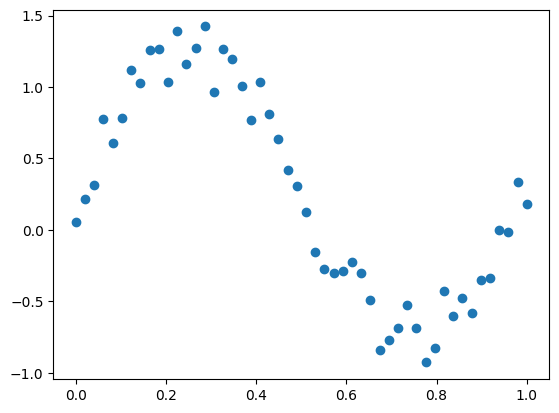

In [238]:
import numpy as np
X_train = np.linspace(0,1,50).reshape(-1,1)
y_train = np.sin(2*np.pi*X_train).squeeze()
y_train = y_train + + 0.5*np.random.rand(len(y_train))
plt.scatter(X_train,y_train)

In [245]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from jax.scipy.linalg import cho_factor, cho_solve
import optax

# RBF Kernel function with length_scale as a vector
def rbf_kernel(x1, x2, length_scale, variance):
    sqdist = jnp.sum(((x1 - x2) / length_scale) ** 2)
    return variance * jnp.exp(-0.5 * sqdist)

# Efficient kernel matrix computation using vmap
def kernel_matrix(X1, X2, length_scale, variance, noise, include_noise=True):
    pairwise_dists = jnp.sum(
        ((X1[:, None, :] - X2[None, :, :]) / jnp.broadcast_to(length_scale, X1[:, None, :].shape)) ** 2, 
        axis=-1)
    K = variance * jnp.exp(-0.5 * pairwise_dists)
    if include_noise:
        K += (noise + 1e-6) * jnp.eye(X1.shape[0]) 
    return K

# Compute alpha and diagonal elements of the inverse of K using Cholesky
def compute_alpha_and_diag_inv_K(K_chol, y):
    alpha = cho_solve((K_chol, True), y)
    
    compute_diag = jax.vmap(lambda A,b,i: cho_solve((A,True),b)[i], in_axes=(None,0,0))
    diag_inv_K = compute_diag(K_chol,jnp.eye(K_chol.shape[0]), jnp.arange(K_chol.shape[0])) 
    
    return alpha, diag_inv_K

# LOO-CV objective function
def loo_cv_objective(params, X, y):
    log_length_scale, log_variance, log_noise = params[:-2], params[-2], params[-1]
    length_scale, variance, noise = jnp.exp(log_length_scale), jnp.exp(log_variance), jnp.exp(log_noise)
    
    K = kernel_matrix(X, X, length_scale, variance, noise)
    K_chol = cho_factor(K, lower=True)[0]
    
    # Compute alpha and diagonal of K_inv using Cholesky factorization
    alpha, diag_inv_K = compute_alpha_and_diag_inv_K(K_chol, y)
    
    # LOO predictive mean and variance
    loo_means = y - alpha / diag_inv_K
    loo_vars = 1/diag_inv_K
    
    # LOO predictive log-probability
    loo_cv_log_score = -0.5 * jnp.sum(jnp.log(loo_vars.squeeze()) + \
                                      (y.squeeze() - loo_means.squeeze())**2 / loo_vars.squeeze())
    return -loo_cv_log_score, loo_means, loo_vars

# JIT compile the objective function for faster optimization
# loo_cv_objective_jit = jit(loo_cv_objective)

# JIT compile the objective function for faster optimization
loo_cv_objective_jit = jit(lambda params, X, y: loo_cv_objective(params, X, y)[0])



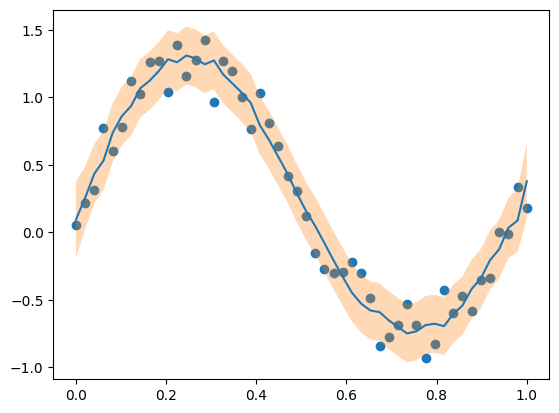

In [261]:
# %%script true
# plotting the loo_means and loo_vars
init_params = jnp.log(jnp.array([0.2,1.0,0.01]))
_,loo_means,loo_vars = loo_cv_objective(init_params,X_train,y_train)

plt.scatter(X_train,y_train)
plt.plot(X_train, loo_means)
plt.fill_between(X_train.squeeze(), loo_means + 2*jnp.sqrt(loo_vars),
                 loo_means - 2*jnp.sqrt(loo_vars),alpha=0.3)


In [255]:
# Initial parameters: log(length_scale), log(variance), log(noise)
init_params = jnp.log(jnp.concatenate((0.5*jnp.ones(X_train.shape[1]),
                                       jnp.array([0.1]), 
                                       jnp.array([0.5]))
                                       ) 
                                       )  # Adjust length to match X_train.shape[1] + 2

# Define the optimizer
optimizer = optax.adam(learning_rate=0.1)
opt_state = optimizer.init(init_params)

# Define the update step
@jit
def update(params, opt_state, X, y):
    loss, grads = value_and_grad(loo_cv_objective_jit)(params, X, y)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

# Training loop
params = init_params
num_steps = 1000
for step in range(num_steps):
    loss, params, opt_state = update(params, opt_state, X_train, y_train)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss}")
        # print(f"Lenghtscale: {jnp.round(jnp.exp(params[:-2]),decimals=0)}, \
        #       Variance:  {jnp.round(jnp.exp(params[-2]),decimals=0)}, \
        #         Noise: {jnp.round(jnp.exp(params[-1]),decimals=0)}")

# Get the optimized parameters
optimized_params = jnp.exp(params)
length_scale, variance, noise = optimized_params[:-2], optimized_params[-2], optimized_params[-1]
print("Optimized Length Scale:", length_scale)
print("Optimized Variance:", variance)
print("Optimized Noise:", noise)


Step 0, Loss: -4.5620551109313965
Step 100, Loss: -68.73345947265625
Step 200, Loss: -68.73382568359375
Step 300, Loss: -68.73385620117188
Step 400, Loss: -68.7337875366211
Step 500, Loss: -68.73387145996094
Step 600, Loss: -68.73384094238281
Step 700, Loss: -68.73379516601562
Step 800, Loss: -68.73377990722656
Step 900, Loss: -68.73381042480469
Optimized Length Scale: [0.16920292]
Optimized Variance: 0.5329765
Optimized Noise: 0.019698717


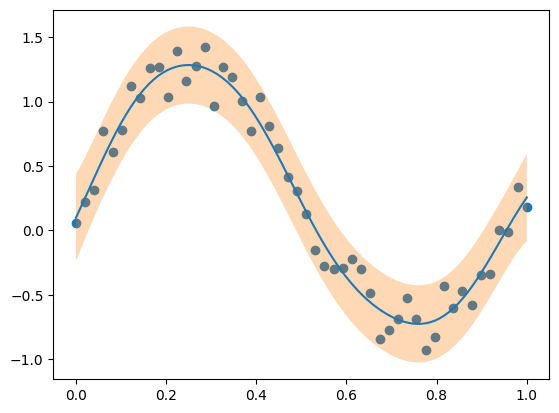

In [256]:
# Function to make predictions with the optimized GP
def predict_gp(X_train, y_train, X_test, length_scale, variance, noise):
    # Compute the kernel matrices
    K = kernel_matrix(X_train, X_train, length_scale, variance, noise)
    K_s = kernel_matrix(X_test, X_train, length_scale, variance, noise, include_noise=False)
    K_ss = kernel_matrix(X_test, X_test, length_scale, variance, noise)

    # Cholesky factorization of K
    K_chol = cho_factor(K, lower=True)[0]
    
    # Compute the mean and variance of the predictive distribution
    alpha = cho_solve((K_chol, True), y_train)
    v = cho_solve((K_chol, True), K_s.T)
    
    mu_s = K_s @ alpha
    cov_s = K_ss - K_s @ v
    
    return mu_s, jnp.diag(cov_s)

X_test = jnp.linspace(0,1,100).reshape(-1,1)
mu_s, var_s = predict_gp(X_train, y_train, X_test, length_scale, variance, noise)
plt.scatter(X_train, y_train)
plt.plot(X_test,mu_s)
plt.fill_between(X_test.squeeze(),mu_s + 2*jnp.sqrt(var_s),
                 mu_s - 2*jnp.sqrt(var_s), alpha=0.3)

In [156]:
jnp.var(y_train)

Array(0.48413315, dtype=float32)